In [3]:
pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 69.7 MB/s eta 0:00:00


In [6]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=867255 sha256=0b18b7f23fa253105fa1eb8447b0a144415630bfed58410b4b4a5e46bf3e1c03
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [ ]:
pip install lightgbm

In [41]:
import pandas as pd
import numpy as np
from numpy import save, load
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy import sparse
from scipy.sparse import csr_matrix, coo_matrix
import itertools
import random
from tqdm import tqdm
from implicit.nearest_neighbours import BM25Recommender, CosineRecommender, TFIDFRecommender
from implicit.evaluation import mean_average_precision_at_k, ndcg_at_k, AUC_at_k
from implicit.als import AlternatingLeastSquares
from lightfm import LightFM
from lightfm.evaluation import recall_at_k, precision_at_k, auc_score
import lightgbm

In [9]:
path = "/content/drive/MyDrive/WB School/data.csv.gzip"
df = pd.read_csv(path, compression='gzip')
df["order_ts"] = pd.to_datetime(df["order_ts"])

# Шаг 1. Подготовка данных

In [10]:
def extract_reluctant_users(df, threshold=5, both=False):

  len_df = len(df)
  df = df.drop_duplicates()
  df_count = df.groupby(["user_id", "item_id"], as_index=False).count().rename(columns={"order_ts": "counter"})

  df_count_users = df_count.groupby("user_id", as_index=False)["counter"].sum()
  users = df_count_users.loc[df_count_users.counter <= threshold, "user_id"].values

  df_reluctants = df[df.user_id.isin(users)]
  df = df[~df.user_id.isin(users)]

  if both:
    return df_reluctants, df
  else:
    return df


def drop_rare_items(df, threshold=2):

  df_temp = df.drop_duplicates()
  df_count = df_temp.groupby(["user_id", "item_id"], as_index=False).count().rename(columns={"order_ts": "counter"})
  df_count_items = df_count.groupby("item_id", as_index=False)["counter"].sum()

  items = df_count_items.loc[df_count_items.counter <= threshold, "item_id"].values
  df = df[~df.item_id.isin(items)]

  return df


def train_test(df, by, test_weeks=1, test_size=0.2):

  if by == "time":

    n_folds = 13 / test_weeks

    delta = (df["order_ts"].max() - df["order_ts"].min()) / n_folds
    edge = df["order_ts"].max() - delta

    train = df.loc[df["order_ts"] <= edge]
    test = df.loc[df["order_ts"] > edge]

    return train, test

  elif by == "percents":

    train_size = 1 - test_size
    idx = int(len(df) * train_size)

    train = df[:idx]
    test = df[idx:]

    return train, test


def common_only(df1, df2, column="users"):

  users = list(set(df1[column]).intersection(set(df2[column])))

  df1_new = df1[df1[column].isin(users)]
  df2_new = df2[df2[column].isin(users)]

  return df1_new, df2_new


def csr_matrix_via_encoder(train, test): # Датафреймы должны быть сгруппированными!

  user_encoder, item_encoder = LabelEncoder(), LabelEncoder()

  users_final = set(train.user_id.unique()).intersection(set(test.user_id.unique()))
  user_encoder.fit(list(users_final))

  all_items = set(train.item_id.unique()).union(set(test.item_id.unique()))
  item_encoder.fit(list(all_items))

  train["user_new_id"] = user_encoder.transform(train["user_id"])
  test["user_new_id"] = user_encoder.transform(test["user_id"])

  train["item_new_id"] = item_encoder.transform(train["item_id"])
  test["item_new_id"] = item_encoder.transform(test["item_id"])

  matrix_shape = len(user_encoder.classes_), len(item_encoder.classes_)

  train_sparse = coo_matrix((list(train.counter.astype(np.float32)),
                            (list(train.user_new_id.astype(np.int64)),
                              list(train.item_new_id.astype(np.int64)))), shape=matrix_shape)

  train_csr = train_sparse.tocsr()

  test_sparse = coo_matrix((list(test.counter.astype(np.float32)),
                           (list(test.user_new_id.astype(np.int64)),
                            list(test.item_new_id.astype(np.int64)))), shape=matrix_shape)

  test_csr = test_sparse.tocsr()

  return train_csr, test_csr, train, test

In [11]:
df_new = extract_reluctant_users(df, threshold=20)
df_new = drop_rare_items(df_new, threshold=10)

train_global, test_global = train_test(df_new, by="time", test_weeks=1)

train_global, test_global = common_only(train_global, test_global, column="user_id")
train_global = extract_reluctant_users(train_global)

train_global = drop_rare_items(train_global, threshold=20)

train_global, test_global = common_only(train_global, test_global, column="user_id")
train_global, test_global = common_only(train_global, test_global, column="item_id")

train_global, test_global = common_only(train_global, test_global, column="user_id")
train_global, test_global = common_only(train_global, test_global, column="item_id")

train_global_grouped = train_global.groupby(["user_id", "item_id"], as_index=False).count().rename(columns={"order_ts": "counter"})
test_global_grouped = test_global.groupby(["user_id", "item_id"], as_index=False).count().rename(columns={"order_ts": "counter"})

train_global_grouped = train_global_grouped.sort_values("user_id")
test_global_grouped = test_global_grouped.sort_values("user_id")

train_global_csr, test_global_csr, train, test = csr_matrix_via_encoder(train_global_grouped, test_global_grouped)

In [12]:
del df
del df_new

del train_global
del test_global

# Шаг 2. Простые модели

In [ ]:
model_cos = CosineRecommender(K=10)
model_cos.fit(train_global_csr.T)

In [ ]:
model_tfidf = TFIDFRecommender()
model_tfidf.fit(train_global_csr.T)

In [ ]:
model_BM25 = BM25Recommender(K=1.2,
                             K1=100,
                             B=0.8)
model_BM25.fit(train_global_csr)

In [ ]:
model_ALS = AlternatingLeastSquares(factors=10,
                                    iterations=10,
                                    regularization=0.00003,
                                    alpha=6)
model_ALS.fit(train_global_csr)

# Шаг 3. Отбор кандидатов + бустинг

## Выбор моделей

In [ ]:
model_warp = LightFM(no_components=40,
                     learning_schedule="adagrad",
                     loss="warp",
                     learning_rate=0.04,
                     item_alpha=0.0001,
                     user_alpha=0.00005,
                     max_sampled=40)

model_warp.fit(train_global_csr, epochs=20)

In [ ]:
model_bpr = LightFM(no_components=12,
                    learning_schedule="adagrad",
                    loss="bpr",
                    learning_rate=0.035,
                    item_alpha=0.00001,
                    user_alpha=0.0001)

model_bpr.fit(train_global_csr, epochs = 20)

In [ ]:
model_lmf = LightFM(no_components=11,
                    learning_schedule="adagrad",
                    loss="logistic",
                    learning_rate=0.019,
                    item_alpha=0.00023,
                    user_alpha=0.00017)

model_lmf.fit(train_global_csr, epochs = 20)

In [ ]:
model_warp_kos = LightFM(no_components=17,
                         k=3,
                         n=11,
                         learning_schedule="adagrad",
                         loss="warp-kos",
                         learning_rate=0.027,
                         item_alpha=0.00001,
                         user_alpha=0.00014,
                         max_sampled=42)

model_warp_kos.fit(train_global_csr, epochs=20)

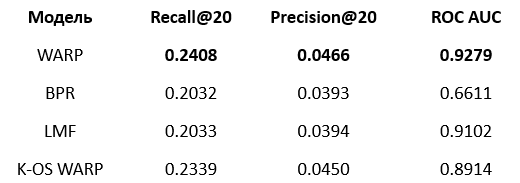

В основе WARP и k-OS WARP  лежит в целом одинаковая идея, и одно является доработанной версией другого, поэтому вместе с WARP вместо  k-OS WARP берём LMF.

## Бустинг

Извлекаем кандидатов.

In [13]:
def candidates_extraction(model_type, users_test, items_test, top=50, precomputed_scores=True):

  if precomputed_scores == True:
    path = "/content/drive/MyDrive/WB School/L4/" + model_type + "_pairs_global.npy"
    pairs = load(path)

  elif precomputed_scores == False:
    path_item_emb = "/content/drive/MyDrive/WB School/" + model_type + "_item_emb_global.npy"
    path_user_emb = "/content/drive/MyDrive/WB School/" + model_type + "user_emb_global.npy"
    path_user_bias = "/content/drive/MyDrive/WB School/" + model_type + "user_biases_global.npy"
    path_item_bias = "/content/drive/MyDrive/WB School/" + model_type + "item_biases_global.npy"

    item_emb = load(path_item_emb)
    user_emb = load(path_user_emb)
    user_biases = load(path_user_bias)
    item_biases = load(path_item_bias)

    pairs = scores_calculation(user_emb, item_emb, user_biases, item_biases, items_number=50)

  model_dict = dict()
  for user, user_data in enumerate(pairs):
        for rank, (item, score) in enumerate(user_data):
            key = tuple([user, item])
            value = tuple([score, (rank + 1)])
            model_dict[key] = value

  model_pairs = list()
  for key in model_dict.keys():
      model_pairs.append(key)

  return model_pairs, model_dict

In [16]:
users_test = sorted(list(set(coo_matrix(train_global_csr).row)))
items_test = sorted(list(set(coo_matrix(train_global_csr).col)))

In [17]:
del train_global_csr

In [18]:
warp_pairs, warp_dict = candidates_extraction("warp", users_test, items_test, top=50, precomputed_scores=True) # 3.6 GB
lmf_pairs, lmf_dict = candidates_extraction("lmf", users_test, items_test, top=50, precomputed_scores=True)

total_pairs = list(set(warp_pairs).union(set(lmf_pairs)))

In [19]:
del warp_pairs
del lmf_pairs

In [22]:
data_all_pairs = [pair +
                  warp_dict.get(pair, (np.nan, np.nan)) +
                  lmf_dict.get(pair, (np.nan, np.nan))  for pair in tqdm(total_pairs)]

100%|██████████| 18873543/18873543 [00:32<00:00, 575496.90it/s]


In [23]:
del warp_dict
del lmf_dict

In [24]:
data_all_pairs_df = pd.DataFrame(data_all_pairs,
                                 columns=["user_id", "item_id", "warp_score", "warp_rank",
                                                                "lmf_score", "lmf_rank"])

In [25]:
del data_all_pairs

In [26]:
def change_dtype(df):

    for column in df.columns:
        if column.endswith("id"):
            df[column] = df[column].astype(np.int32)
        else:
            df[column] = df[column].astype(np.float32)

    return df

In [27]:
data_all_pairs_df = change_dtype(data_all_pairs_df)

In [28]:
def fill_nans(df, top=50):

    for column in df.columns:
        if column.endswith("score"):
            df[column] = df[column].fillna(random.uniform(0, 1))
        elif column.endswith("rank"):
            df[column] = df[column].fillna(random.randint(top, (top + 100))) # Чтобы отдалить незаказанные айтемы

    return df

In [29]:
predictions = fill_nans(data_all_pairs_df, top=50)

In [30]:
purchases = list()

for k in tqdm(range(test_global_csr.shape[0])):
  cx = coo_matrix(test_global_csr[k])
  purchased_items, user_id = [], []
  user_id.append(k)

  for i,j,v in zip(cx.row, cx.col, cx.data):
    purchased_items.append(j)

  for i in list(itertools.product(user_id, purchased_items)):
    purchases.append(i)

100%|██████████| 233086/233086 [00:45<00:00, 5158.94it/s]


In [31]:
del test_global_csr

In [32]:
def purchases2dict(purchases):

    data_true = {}
    for i in tqdm(purchases):
        curr, item = i[0], int(i[1])

        if curr not in data_true:
            data_true[curr] = list()
            data_true[curr].append(item)
        else:
            data_true[curr].append(item)

    for i in tqdm(data_true.keys()):
        data_true[i] = set(data_true[i])

    return data_true

In [33]:
data_true = purchases2dict(purchases)

100%|██████████| 233086/233086 [00:00<00:00, 942350.98it/s]


In [34]:
del purchases

In [35]:
items_dict = dict(zip(train.item_new_id, train.item_id))
users_dict = dict(zip(train.user_new_id, train.user_id))

In [36]:
del train

In [37]:
predictions["user_id"] = predictions["user_id"].map(users_dict)
predictions["item_id"] = predictions["item_id"].map(items_dict)

In [38]:
del items_dict
del users_dict

In [39]:
test["target"] = 1

dataset = pd.merge(predictions,
                   test[["user_id", "item_id", "target"]].drop_duplicates(),
                   how="left",
                   left_on=["user_id", "item_id"],
                   right_on=["user_id", "item_id"])

dataset["target"].fillna(0, inplace=True)
dataset = dataset.dropna()

In [40]:
del test
del predictions

In [45]:
train_xy, test_xy = train_test_split(dataset, train_size=0.7, random_state=42)

In [46]:
# Нужно только расчёта NDCG
relevance_df_test = test_xy[["user_id", "item_id", "target"]]
relevance_df_test = relevance_df_test[relevance_df_test["target"] == 1.0]

relevance_df_test.to_csv("relevance_df_test.csv")

In [47]:
del relevance_df_test

In [50]:
y_train = train_xy.pop("target")
x_train = train_xy.copy()

y_test = test_xy.pop("target")
x_test = test_xy.copy()

X_train = x_train[["warp_score", "warp_rank", "lmf_score", "lmf_rank"]]
X_test = x_test[["warp_score", "warp_rank", "lmf_score", "lmf_rank"]]

x_train = x_train.sort_values("user_id").reset_index(drop=True)
x_test = x_test.sort_values("user_id").reset_index(drop=True)

train_query = x_train["user_id"].value_counts().sort_index()
test_query = x_test["user_id"].value_counts().sort_index()

In [51]:
del x_train
del train_xy
del test_xy

In [52]:
model_gbm = lightgbm.LGBMRanker(n_estimators=500,
                                objective="lambdarank",
                                random_state=42)
model_gbm.fit(X_train,
              y_train,
              group=train_query,
              eval_set=[(X_test, y_test)],
              eval_group=[list(test_query)],
              eval_at=[20],
              early_stopping_rounds=50,
              verbose=0)

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRanker(n_estimators=500, objective='lambdarank', random_state=42)

In [ ]:
lgb_test = x_test.copy()
# lgb_test[["user_id", "item_id"]].drop_duplicates(inplace=True)
lgb_test.set_index(["user_id", "item_id"], inplace=True)
lgb_test["lgb_score"] = model_gbm.predict(lgb_test)
# lgb_test = lgb_test.set_index("lgb_score", append=True).sort_values("lgb_score", ascending=False)
# lgb_test.drop_duplicates(inplace=True)

dataset_predicted = dict()
lgb_test.reset_index(inplace=True)
for user, group in tqdm(lgb_test.groupby("user_id")):
    dataset_predicted[user] = list(group.sort_values(by="lgb_score", ascending=False).item_id)[:20]

# Шаг 4. Сравнение результатов

Все модели обучались на train_global, замеры делались на test_global.

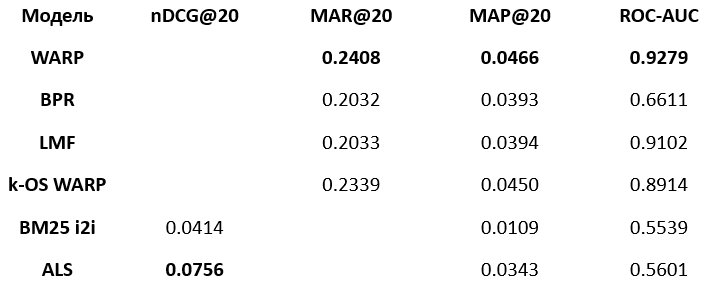